# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
from collections import defaultdict

import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

# custom utilities
from graph_utils import (
    calc_avg_degree, 
    implied_beta, 
    scale_free_graph, 
    setup_experiment,
    popularity,
    prob_large_cascade,
    mean_virality,
    size_virality_corr
)

In [2]:
G = scale_free_graph(1000, alpha=2.3)
k = calc_avg_degree(G)
print(f"Average degree (k): {k}")
r = 0.5 # if r = 0.5, what is the beta implied?
print(f"Implied infectiousness when r={r}: {implied_beta(k,r)}")

Average degree (k): 30.52
Implied infectiousness when r=0.5: 0.0163826998689384


Text(0.5, 1.0, 'Frequency of out-degree for nodes in scale-free network')

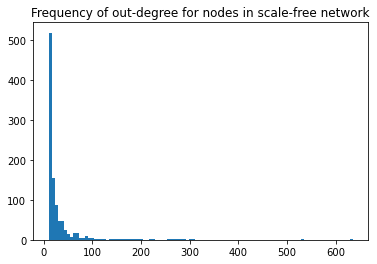

In [5]:
# plot degrees of nodes
degrees = [deg for n, deg in G.in_degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of out-degree for nodes in scale-free network")

Text(0.5, 1.0, 'Frequency of in-degree for nodes in scale-free network')

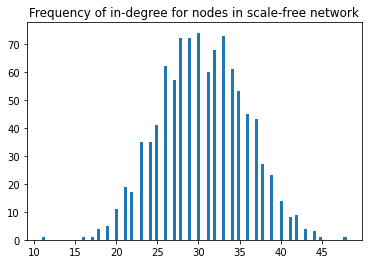

In [6]:
# plot degrees of nodes
degrees = [deg for n, deg in G.out_degree()]
plt.hist(degrees, bins=100)
plt.title("Frequency of in-degree for nodes in scale-free network")

In [7]:
def graph_popularity(sizes):
    plt.hist(sizes, bins=100)
    plt.title("Frequency of cascade sizes")
    plt.xlabel("Size")
    plt.ylabel("Frequency")

# Run simulation with 10k users


In [12]:
# test bass model
num_users = 10000
num_graphs = 30 # each (alpha,r) setting will be tested with this # of graphs
trials_per_graph = 100 # each graph will have separate simulations with this # of trials

# varying alpha and R
alphas = [2.1, 2.5, 2.9]
# rs = [0.1, 0.3, 0.5, 0.7, 0.9]
rs = [0.1, 0.5,  0.9]

# save result in a dictionary
# that has (alpha-r) as the key
# e.g.: 
#     {
#         (2.1, 0.1): {
#             "size" : np.array, # len: num_trials
#             "viralitys" : np.array, # len: num_trials
#         }
#     }
results = defaultdict(dict)

for alpha, r in zip(alphas, rs):
    print(f"Testing pair of parameters alpha={alpha}, r={r} at time {datetime.datetime.now()}...")
    
    total_trials = num_graphs * trials_per_graph
    size_arr = np.zeros(total_trials)
    vir_arr = np.zeros(total_trials)
    trial_idx = 0
    
    for i in range(num_graphs):
        G = scale_free_graph(num_users, alpha=alpha)
        user_rep = nx.convert_matrix.to_numpy_array(G) # convert to numpy adjacency matrix
        # calculate required item infectiousness
        k = calc_avg_degree(G)
        
        if i % 10 == 0:
            print(f"\tOn graph {i} at time {datetime.datetime.now()}...")
            
        for j in range(trials_per_graph):
            simulation = setup_experiment(user_rep, k, r=r)
            simulation.run()
            size = popularity(simulation)
            size_arr[trial_idx] = size
            try:
                sv = simulation.get_structural_virality()
                vir_arr[trial_idx] = sv
            except:
                vir_arr[trial_idx] = -1 # couldn't calculate virality
            trial_idx += 1

    results[(alpha, r)]["size"] = size_arr
    results[(alpha, r)]["virality"] = vir_arr
    
    print("")

Testing pair of parameters alpha=2.1, r=0.1 at time 2021-02-02 20:12:04.449584...
	On graph 0 at time 2021-02-02 20:12:07.534901...
	On graph 10 at time 2021-02-02 20:42:26.249264...
	On graph 20 at time 2021-02-02 21:11:43.603987...


KeyboardInterrupt: 

# Load experimental results

Experimental procedure:
- Run `create_graphs.py`. Make sure to modify the constants in the main function to generate correct # of graphs with the correct # of nodes and with the right values for $\alpha$. This will create a new folder with graphs inside.
- Run `run_sim.py`. Alter the constants at the top to make sure it reads the right graphs from your graph directory. Also, specify how many simulations should be run per graph. This file will save the results of the simulations in the filename specified.

In [9]:
f = open("sv_sims_10k_nodes.pkl", "rb")
results = pkl.load(f)
f.close()

In [14]:
def extract_alpha_rs(results_dict):
    """ Result the alpha and rs for the results dictionary.
    """
    alpha_set = set()
    r_set = set()
    for alpha, r in results_dict.keys():
        alpha_set.add(alpha)
        r_set.add(r)
    return sorted(list(alpha_set)), sorted(list(r_set))

In [15]:
alphas, rs = extract_alpha_rs(results)

In [16]:
# graphing
colors=['red', 'orange', 'green', 'blue', 'purple']

Text(0, 0.5, 'Probability of popularity (%)')

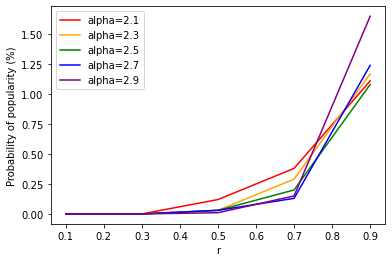

In [20]:
popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    popularity_chance[alpha] = [prob_large_cascade(results[(alpha, r)]["size"]) * 100 for r in rs]
    plt.plot(rs, popularity_chance[alpha], label=f"alpha={alpha}", color=colors[i])
leg = plt.legend()
plt.xlabel("r")
plt.ylabel("Probability of popularity (%)")

Text(0, 0.5, 'Mean structural virality')

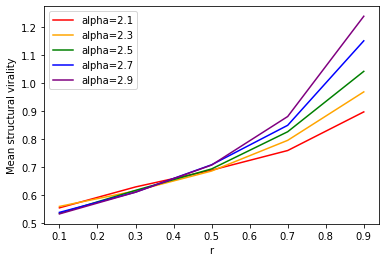

In [18]:
avg_virality = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    avg_virality[alpha] = [mean_virality(results[(alpha, r)]["virality"]) for r in rs]
    plt.plot(rs, avg_virality[alpha], label=f"alpha={alpha}", color=colors[i])
plt.legend()
plt.xlabel("r")
plt.ylabel("Mean structural virality")

Text(0, 0.5, 'Correlation between size and structural virality')

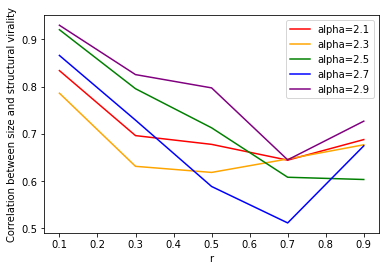

In [19]:
size_vir_corr = {} # map from alpha to list, where each element corresponds to one R value
for i, alpha in enumerate(alphas):
    size_vir_corr[alpha] = [size_virality_corr(results[(alpha, r)]["size"], results[(alpha, r)]["virality"]) for r in rs]
    plt.plot(rs, size_vir_corr[alpha], label=f"alpha={alpha}",color=colors[i])
plt.legend()
plt.xlabel("r")
plt.ylabel("Correlation between size and structural virality")

In [ ]:
graph_popularity(sizes)

In [ ]:
print(f"Probability of a large cascade: {prob_large_cascade(sizes)}")
print(f"Mean structural virality: {mean_virality(viralitys)}")
print(f"Correlation between popularity and structural virality: {size_virality_corr(sizes, viralitys)}")

# Test with sparse matrices

In [ ]:
from scipy.sparse import csr_matrix, save_npz
import pickle as pkl
import os

In [ ]:
num_nodes = 1000000

print(f"Started creating graph at time {datetime.datetime.now()}...")
G = scale_free_graph(num_nodes, alpha=2.3)
print(f"Finished creating graph at time {datetime.datetime.now()}...")
user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
# calculate required item infectiousness
k = calc_avg_degree(G)
beta = implied_beta(k, r)
item_rep = np.array([[beta]]) # must be two dimensional

# seed infection with 1 user
infection_state = np.zeros(user_rep.shape[0]).reshape(-1, 1) # must be two dimensional array
seed_user = np.random.choice(num_nodes, 1)
infection_state[seed_user, 0] = 1

# create model
bass = BassModel(
    user_representation=user_rep,
    item_representation=item_rep,
    infection_state=infection_state
)
print(f"Finished creating model at time {datetime.datetime.now()}...")

In [ ]:
# try to create as many graphs as I can overnight
num_nodes = 1000000
for i in range(75):
    param_dict = {}
    os.mkdir(f"graphs_1m/{i}")
    G = scale_free_graph(num_nodes, alpha=2.3)
    print(f"Finished creating graph {i} at time {datetime.datetime.now()}...")
    user_rep = nx.convert_matrix.to_scipy_sparse_matrix(G) # convert to scipy adjacency matrix
    save_npz(f'graphs_1m/{i}/sparse_matrix.npz', user_rep)
    param_dict["k"] = calc_avg_degree(G)
    param_dict["beta"] = implied_beta(k, r)
    param_dict["num_nodes"] = num_nodes
    f = open(f'graphs_1m/{i}/param.pkl', 'wb')
    pkl.dump(param_dict, f, -1)
    f.close()
    break
    

In [ ]:
bass.run()
size = popularity(bass)
try:
    sv = bass.get_structural_virality()
except:
    pass

In [ ]:
print(size)
print(sv)